In [11]:
import kagglehub


# Download latest version
path = kagglehub.dataset_download("omarshahrukh/bitcoin-daily-prices-2014-2023-9-years", output_dir='data')

print("Path to dataset files:", path)

C:\Users\arche\PycharmProjects\bitcoin-prices\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: data


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from collections import OrderedDict


In [3]:
class BitcoinDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.features = torch.tensor(data.drop('Target_Close', axis=1).values, dtype=torch.float32)
        self.targets = torch.tensor(data['Target_Close'].values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


In [4]:
class BitcoinClosingPricePredictor(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(input_size, 64)),
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(64, 32)),
            ('relu2', nn.ReLU()),
            ('output', nn.Linear(32, output_size)),
        ]))

    def forward(self, x):
        return self.layers(x)

In [5]:
data = pd.read_csv('data/Bitcoin_Price_Dataset_2014_2023.csv', na_values=['?'])
data

,Date,Open,High,Low,Close,Volume,Daily_Return,Price_Range,Price_Change,MA_7,MA_30,MA_90,Volatility_30d,Day_of_Week,Month,Year,Quarter
0,2014-09-17,465.86,468.17,452.42,457.33,21056800,NaN,15.75,-8.53,NaN,NaN,NaN,NaN,Wednesday,9,2014,3
1,2014-09-18,456.86,456.86,413.10,424.44,34483200,-7.19,43.76,-32.42,NaN,NaN,NaN,NaN,Thursday,9,2014,3
2,2014-09-19,424.10,427.83,384.53,394.80,37919700,-6.98,43.30,-29.31,NaN,NaN,NaN,NaN,Friday,9,2014,3
3,2014-09-20,394.67,423.30,389.88,408.90,36863600,3.57,33.41,14.23,NaN,NaN,NaN,NaN,Saturday,9,2014,3
4,2014-09-21,408.08,412.43,393.18,398.82,26580100,-2.47,19.24,-9.26,NaN,NaN,NaN,NaN,Sunday,9,2014,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3388,2023-12-27,42518.47,43683.16,42167.58,43442.86,25260941032,2.17,1515.58,924.39,43457.02,42106.89,35822.24,2.33,Wednesday,12,2023,4
3389,2023-12-28,43468.20,43804.78,42318.55,42627.86,22992093014,-1.88,1486.23,-840.34,43279.69,42266.78,35996.86,2.36,Thursday,12,2023,4
3390,2023-12-29,42614.64,43124.32,41424.06,42099.40,26000021055,-1.24,1700.26,-515.24,43008.47,42408.15,36164.99,2.38,Friday,12,2023,4
3391,2023-12-30,42091.75,42584.12,41556.23,42156.90,16013925945,0.14,1027.90,65.15,42782.38,42556.28,36322.47,2.38,Saturday,12,2023,4


In [6]:
data['Target_Close'] = data['Close'].shift(-1)

data = data.dropna(axis=0)
# Cleaning Nones in Daily_Return, MA_7, MA_30, MA_90, Volatility_30

numeric_data = data.drop(columns=['Date', 'Day_of_Week'])

train_df, rest_df = train_test_split(numeric_data, test_size=0.2, shuffle=False)

val_df, test_df = train_test_split(rest_df, test_size=0.5, shuffle=False)

scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)


# Transforming back to dataframe to feed it to dataloader

train_scaled = pd.DataFrame(train_scaled, columns=numeric_data.columns)
val_scaled = pd.DataFrame(val_scaled, columns=numeric_data.columns)
test_scaled = pd.DataFrame(test_scaled, columns=numeric_data.columns)


train_dataset = BitcoinDataset(train_scaled)
val_dataset = BitcoinDataset(val_scaled)
test_dataset = BitcoinDataset(test_scaled)


batch_size = 32 # standard value

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_features = train_scaled.shape[1] - 1

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BitcoinClosingPricePredictor(input_size=num_features, output_size=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    batch_train_losses = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()              # 1. Clear old gradients

        outputs = model(X_batch)           # 2. Forward pass: predict prices for this batch
        loss = criterion(outputs, y_batch) # 3. Calculate the error (MSE)

        loss.backward()                    # 4. Backward pass: compute gradients
        optimizer.step()                   # 5. Update weights

        batch_train_losses.append(loss.item())

    epoch_train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(epoch_train_loss)

    model.eval()
    batch_val_losses = []

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            val_outputs = model(X_val_batch)
            val_loss = criterion(val_outputs, y_val_batch)
            batch_val_losses.append(val_loss.item())

    epoch_val_loss = sum(batch_val_losses) / len(batch_val_losses)
    val_losses.append(epoch_val_loss)

    if (epoch + 1) % 10 == 0:
        print(
            f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

Using device: cuda
Epoch [10/100], Loss: 0.0037, Val Loss: 0.0056
Epoch [20/100], Loss: 0.0061, Val Loss: 0.0065
Epoch [30/100], Loss: 0.0059, Val Loss: 0.0048
Epoch [40/100], Loss: 0.0036, Val Loss: 0.0046
Epoch [50/100], Loss: 0.0034, Val Loss: 0.0081
Epoch [60/100], Loss: 0.0030, Val Loss: 0.0046
Epoch [70/100], Loss: 0.0031, Val Loss: 0.0039
Epoch [80/100], Loss: 0.0028, Val Loss: 0.0045
Epoch [90/100], Loss: 0.0031, Val Loss: 0.0051
Epoch [100/100], Loss: 0.0032, Val Loss: 0.0046


In [27]:
# Evaluation on test set

model.eval()

batch_test_losses = []
# Create lists to store all predictions and true values across all batches
all_predictions = []
all_true_values = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)

        test_outputs = model(X_test_batch)
        test_loss = criterion(test_outputs, y_test_batch)
        batch_test_losses.append(test_loss.item())

        all_predictions.extend(test_outputs.cpu().numpy())
        all_true_values.extend(y_test_batch.cpu().numpy())

# Convert lists to flat numpy arrays for sklearn metrics
all_predictions = np.array(all_predictions).flatten()
all_true_values = np.array(all_true_values).flatten()

# Calculate Regression Metrics
test_mse = mean_squared_error(all_true_values, all_predictions)
test_mae = mean_absolute_error(all_true_values, all_predictions)
test_r2 = r2_score(all_true_values, all_predictions)

print(f'Test MSE (Scaled): {test_mse:.4f}')
print(f'Test MAE (Scaled): {test_mae:.4f}')
print(f'R-squared Score: {test_r2:.4f}')

Test MSE (Scaled): 0.0031
Test MAE (Scaled): 0.0463
R-squared Score: 0.9719


In [28]:
# searching for the exact index of your target column
target_col_name = 'Target_Close'
close_idx = numeric_data.columns.get_loc(target_col_name)

dummy_true = np.zeros((len(all_true_values), len(numeric_data.columns)))
dummy_pred = np.zeros((len(all_predictions), len(numeric_data.columns)))

dummy_true[:, close_idx] = all_true_values
dummy_pred[:, close_idx] = all_predictions

real_true_prices = scaler.inverse_transform(dummy_true)[:, close_idx]
real_pred_prices = scaler.inverse_transform(dummy_pred)[:, close_idx]

# Calculating Dollar MAE
real_mae = mean_absolute_error(real_true_prices, real_pred_prices)
print(f"Real-World Error: On average, the model is off by ${real_mae:.2f}")

Real-World Error: On average, the model is off by $756.92


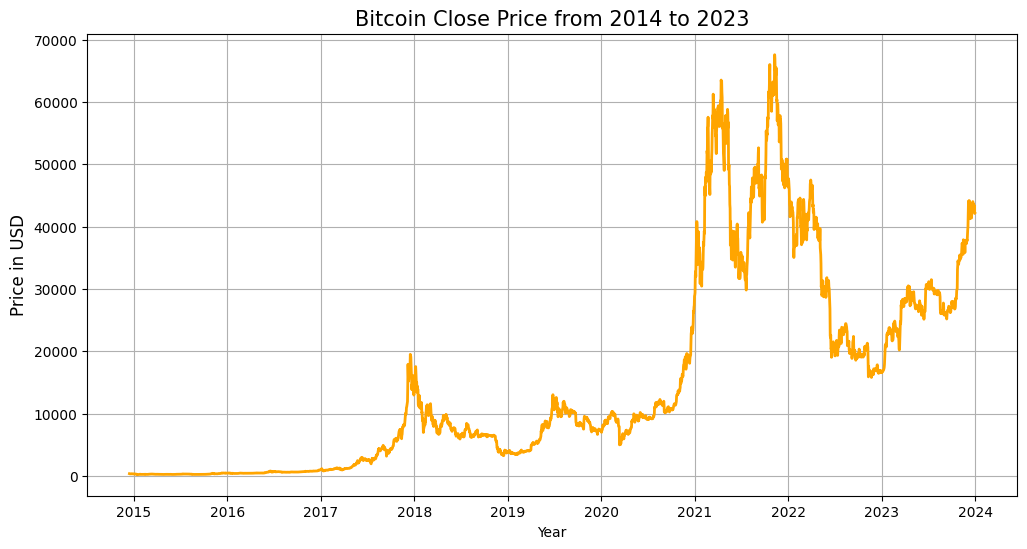

In [29]:
import matplotlib.pyplot as plt
import squarify

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(data['Date']), data['Close'], color='orange', linewidth=2)
plt.title('Bitcoin Close Price from 2014 to 2023', fontsize=15)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Price in USD', fontsize=12)

plt.grid(True)

plt.show()

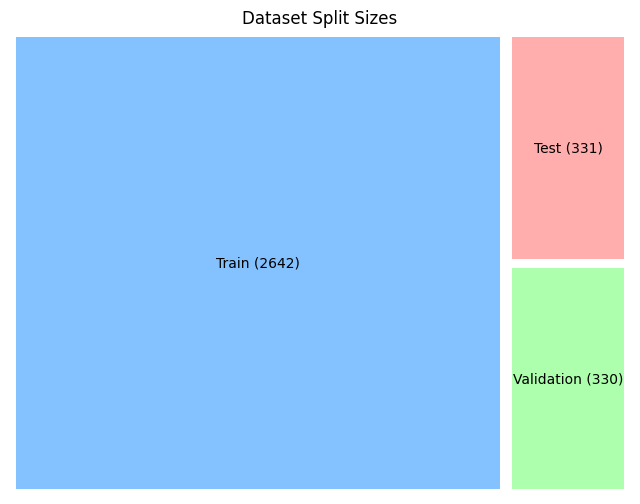

In [30]:
sizes = [len(train_df), len(val_df), len(test_df)]

labels = [f'Train ({len(train_df)})', f'Validation ({len(val_df)})', f'Test ({len(test_df)})']

colors = ['#66b3ff', '#99ff99', '#ff9999']

plt.figure(figsize=(8, 6))

squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, pad=True)

plt.title("Dataset Split Sizes")
plt.axis('off')
plt.show()

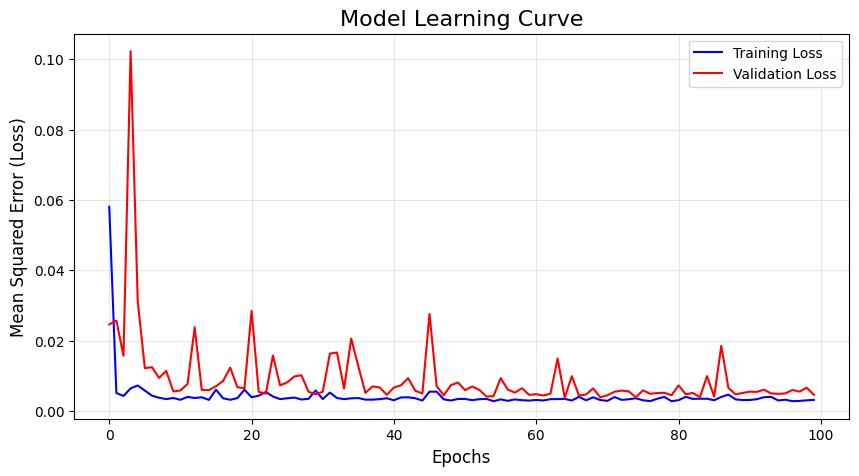

In [31]:
plt.figure(figsize=(10, 5))


plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')

plt.title('Model Learning Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Squared Error (Loss)', fontsize=12)

plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

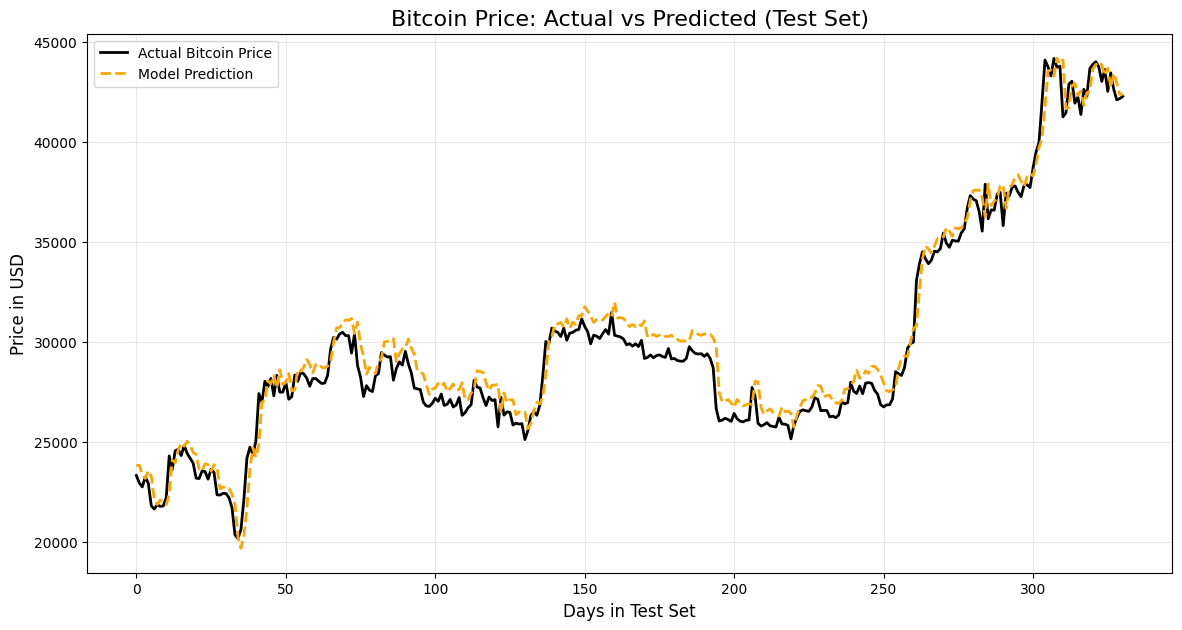

In [32]:
plt.figure(figsize=(14, 7))

plt.plot(real_true_prices, label='Actual Bitcoin Price', color='black', linewidth=2)

plt.plot(real_pred_prices, label='Model Prediction', color='orange', linestyle='dashed', linewidth=2)

plt.title('Bitcoin Price: Actual vs Predicted (Test Set)', fontsize=16)
plt.xlabel('Days in Test Set', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()